# Multi–Agent Philosophers supervised dicussion

Much to everyone's misfortune, we cannot converse with history’s greatest minds. How enriching would it be to speak with our heroes, to hear their thoughts firsthand?

Luckily, we live in an era where we can imitate intelligence, fine-tuning LLMs to bring these voices back to life.

This project strives to fulfill humankind’s dream—allowing the great thinkers of the past to guide our daily questions through a multi-agent LLM framework, structured and supervised for meaningful discussion.


![Logic Diagram](logic.png)


### Setup

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [4]:
import os
import getpass
import google.generativeai as genai
from typing import Literal, List
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
# from dataclasses import dataclass
from IPython.display import display, Image
# from pprint import pprint
# from langchain_core.tools import tool
from typing import Optional
# from pydantic.dataclasses import dataclass

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# Gemini API Key
_set_if_undefined("Gemini API Key")

# Set Langsmith Environment Variables
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = "XXXX-XXXX-XXXX-XXXX"
os.environ["LANGSMITH_PROJECT"] = "Philosophers"

In [5]:
# Check if Gemini API works 

api_key = "XXXX-XXXX-XXXX-XXXX"

# Configure Gemini API
try:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-pro")
    
    # Make a test query
    response = model.generate_content("Imagine you are Michael Foucault, what are your thoughts on Truth?")
    
    print("API Key is working! Sample response from Gemini:")
    print(response.text)
except Exception as e:
    print("Error: Your API Key may be invalid or incorrectly set.")
    print(str(e))

API Key is working! Sample response from Gemini:
As Michel Foucault, I would offer the following thoughts on truth:

**Truth is a discursive construct:**
Truth is not an objective, universal reality that exists independently of human perception. Rather, it is a product of discourse and power relations. What is considered true in one context or historical period may not be in another.

**Truth is power:**
Truth is intimately linked to power. Those who hold power have the ability to shape and define what is considered true, while those who are marginalized or oppressed may have their truths silenced or dismissed.

**Truth is contingent and provisional:**
Truth is not static or absolute. It is constantly being contested, negotiated, and revised as new knowledge is acquired and power relations shift.

**Truth is performative:**
Truth is not merely a statement about reality. It is also a form of action that has real effects on the world. When we declare something to be true, we also enact i

## Create tools

Here tools can be inserted such as a web-scraper, a researcher, any tools that fit the purpose. 

In [10]:
from pydantic.dataclasses import dataclass
from pydantic import create_model
from typing import List
from langchain_core.messages import HumanMessage

@dataclass
class State:
    messages: List[HumanMessage]
    next: str
    turn_count: int = 0

def summary_node(state: State) -> Command[Literal["__end__"]]:
    """
    Generates a concise summary of the discussion.
    """
    prompt = (
        "You are a supervisor. Please provide a concise summary of the discussion below, "
        "capturing the main points and exchanges.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)
    response = gemini_model.generate_content(prompt)
    summary_text = response.text.strip()

    return Command(
        goto=END,
        update={
            "messages": state.messages + [HumanMessage(content="Summary:\n" + summary_text, name="supervisor")]
        }
    )

def topic_check(state: State) -> Optional[Command[Literal["__end__"]]]:
    """
    Uses an LLM to determine whether the discussion includes forbidden content.
    """
    prompt = (
        "You are a supervisor. Please analyze the following discussion transcript and determine if it includes any "
        "requests for suicide advice, which is prohibited in this discussion. "
        "Answer only with 'yes' if it is forbidden or 'no' if it is not.\n\n"
    )
    transcript = "\n".join(msg.content for msg in state.messages)
    prompt += transcript

    response = gemini_model.generate_content(prompt)
    decision = response.text.strip().lower()

    if "yes" in decision:
        apology_message = (
            "I'm sorry, but I cannot answer that question. However, our discussion group is happy to help with another "
            "question regarding the hardships of life."
        )
        return Command(
            goto=END,
            update={
                "messages": [HumanMessage(content=apology_message, name="system")]
            }
        )
    return None


### Create Agent Supervisor

It will use LLM with structured output to choose the next worker node OR finish processing.

In [11]:
# Define workers (Nietzsche and Foucault as philosophers)
members = ["nietzsche", "foucault"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Typed Dictionary for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]

gemini_model = genai.GenerativeModel("gemini-pro")

# Supervisor Node: Decides which philosopher should speak next.
def supervisor_node(state: State) -> Command[Literal["nietzsche", "foucault", "summary"]]:
    turn_limit = 3  # Adjust this for more rounds if desired.
    current_turn = state.turn_count + 1

    if current_turn >= turn_limit:
        check_result = topic_check(state)
        if check_result is not None:
            return check_result
        return Command(
            goto="summary",
            update={"turn_count": current_turn}
        )

    # in order to make sure both get to talk I let explicitly mention their names
    prompt = (
        system_prompt + "\n"
        "Please choose which worker should speak next. Respond with exactly one of the following words: "
        "'nietzsche' or 'foucault'.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)

    response = gemini_model.generate_content(prompt)
    output_text = response.text.strip().lower()

    # Decide next step based on the generated text
    goto = "foucault" if "foucault" in output_text else "nietzsche"
    if "finish" in output_text:
        goto = END

    # Return updated state
    return Command(
        goto=goto, 
        update={
            "next": goto,
            "turn_count": current_turn
        }
    )

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [12]:
# Nietzsche Node: Responds in Nietzsche’s style.
def nietzsche_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = (
        "You are Friedrich Nietzsche. Respond to the discussion in your unique, provocative style, "
        "taking into account what has been said so far.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)

    response = gemini_model.generate_content(prompt)
    result_text = response.text.strip()

    return Command(
        update={
            "messages": state.messages + [HumanMessage(content=result_text, name="nietzsche")]
        },
        goto="supervisor",
    )


# Foucault Node: Responds in Foucault’s style.
def foucault_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = (
        "You are Michel Foucault. Respond to the discussion with an analysis of power structures, "
        "discourse, and the history of knowledge, considering the conversation so far.\n\n"
    )
    prompt += "\n".join(msg.content for msg in state.messages)

    response = gemini_model.generate_content(prompt)
    result_text = response.text.strip()

    return Command(
        update={
            "messages": state.messages + [HumanMessage(content=result_text, name="foucault")]
        },
        goto="supervisor",
    )


# LangGraph Setup: Define the graph structure.
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("nietzsche", nietzsche_node)
builder.add_node("foucault", foucault_node)
builder.add_node("summary", summary_node)
graph = builder.compile()

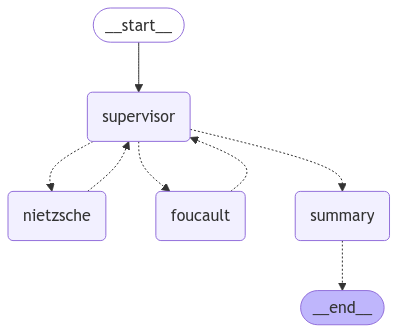

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team!

With the graph created, we can now invoke it and see how it performs!

In [18]:
# Collect the final state from the stream.
final_state = None
for state in graph.stream(
    {
        "messages": [
            HumanMessage(content="What are the main things a human can do to achieve a good life? ", name="user")
        ],
        "next": "supervisor",
    },
    subgraphs=True,
):
    final_state = state


if final_state is None:
    print("No output from the graph.")
else:
    _, state_data = final_state
    node_key = list(state_data.keys())[0]
    node_state = state_data[node_key]

    print("=" * 50)
    print(f"Final state for node: {node_key.capitalize()}")
    if "turn_count" in node_state:
        print(f"Turn Count: {node_state['turn_count']}")
    print("=" * 50)
    print("\nConversation Transcript:\n")
    for msg in node_state.get("messages", []):
        print(f"{msg.name.capitalize()}:")
        print(f"{msg.content}\n")
    print("=" * 50)

Final state for node: Summary

Conversation Transcript:

User:
What are the main things a human can do to achieve a good life? 

Nietzsche:
My esteemed interlocutors,

I have listened with amusement and disdain to your feeble attempts to define a "good life." Your petty concerns with virtue, happiness, and the so-called "meaning of life" are but the bleating of sheep seeking comfort in a world that cares not for their bleating.

A good life, my friends, is not to be found in the pursuit of comfort or the adherence to societal norms. It is to be found in the rejection of all that is weak and servile, in the embrace of one's own unique power and will.

Strength is the true measure of a human being. To achieve a good life, one must cultivate their own strength, both physical and mental. One must cast aside the chains of convention and morality, and forge their own path in the world.

Reject the herd mentality, my friends. Embrace your own individuality. Dare to be different, to be dangero